# **Redes Convolucionales Profundas (CNNs)**
## **Ejercicio: clasificar en female / male caras en color**

La base de datos usada es un subconjunto de la base de datos
"Labeled Faces in the Wild" ("LFW"):

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

  http://vis-www.cs.umass.edu/lfw/

La separación en carpetas "female" / "male" se ha realizado usando
un código basado en:
https://github.com/Pletron/LFWgender

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import os
from PIL import Image

In [2]:
COLAB = True

Si se desea ejecutar en local:

- Descargar el dataset de: https://drive.google.com/file/d/1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei

- Poner variable COLAB a False

In [3]:
!ls -la

total 95396
drwxrwxr-x 6 tomas tomas     4096 Jan 10 13:37 .
drwxrwxr-x 8 tomas tomas     4096 Jan 10 00:41 ..
-rw-rw-r-- 1 tomas tomas   449775 Jan 10 00:27 best_model_color.keras
-rw-rw-r-- 1 tomas tomas   449775 Jan 10 00:26 best_model_gray.keras
-rw-rw-r-- 1 tomas tomas   449778 Jan  9 22:48 best_model.keras
-rw-r--r-- 1 tomas tomas     3247 Mar 11  2022 caras_aux.py
-rw-rw-r-- 1 tomas tomas   463258 Dec 23 14:52 color-base.ipynb
-rw-rw-r-- 1 tomas tomas    32567 Jan 10 13:37 color-cnn.ipynb
-rw-rw-r-- 1 tomas tomas    34272 Jan 10 01:21 color-cnntl.ipynb
-rw-r--r-- 1 tomas tomas     3237 Mar 11  2022 funciones_auxiliares.py
drwxr-xr-x 4 tomas tomas     4096 Nov 11  2019 gender
drwxr-xr-x 4 tomas tomas     4096 Nov 11  2019 gender_color
-rw-rw-r-- 1 tomas tomas 41914348 Mar 11  2022 gender.zip
-rw-rw-r-- 1 tomas tomas   435643 Dec 23 17:37 gris-base.ipynb
drwxrwxr-x 2 tomas tomas     4096 Jan 10 12:39 .ipynb_checkpoints
-rw-r--r-- 1 tomas tomas 52822016 Jan 10 13:37 .jupyter_ystore

### Descarga de datos

## **Funciones auxiliares**

In [4]:
from IPython.display import SVG
from keras.utils import model_to_dot

def display_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

2025-01-10 13:37:58.444349: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 13:37:58.451787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736512678.460017   11379 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736512678.462765   11379 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 13:37:58.471725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss,
                          figsize=(10,4)):
    #best_i = np.argmax(val_acc)
    best_i = np.argmin(val_loss)
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [6]:
!ls -la

total 95384
drwxrwxr-x 6 tomas tomas     4096 Jan 10 13:37 .
drwxrwxr-x 8 tomas tomas     4096 Jan 10 00:41 ..
-rw-rw-r-- 1 tomas tomas   449775 Jan 10 00:27 best_model_color.keras
-rw-rw-r-- 1 tomas tomas   449775 Jan 10 00:26 best_model_gray.keras
-rw-rw-r-- 1 tomas tomas   449778 Jan  9 22:48 best_model.keras
-rw-r--r-- 1 tomas tomas     3247 Mar 11  2022 caras_aux.py
-rw-rw-r-- 1 tomas tomas   463258 Dec 23 14:52 color-base.ipynb
-rw-rw-r-- 1 tomas tomas    32567 Jan 10 13:37 color-cnn.ipynb
-rw-rw-r-- 1 tomas tomas    34272 Jan 10 01:21 color-cnntl.ipynb
-rw-r--r-- 1 tomas tomas     3237 Mar 11  2022 funciones_auxiliares.py
drwxr-xr-x 4 tomas tomas     4096 Nov 11  2019 gender
drwxr-xr-x 4 tomas tomas     4096 Nov 11  2019 gender_color
-rw-rw-r-- 1 tomas tomas 41914348 Mar 11  2022 gender.zip
-rw-rw-r-- 1 tomas tomas   435643 Dec 23 17:37 gris-base.ipynb
drwxrwxr-x 2 tomas tomas     4096 Jan 10 12:39 .ipynb_checkpoints
-rw-r--r-- 1 tomas tomas 52826112 Jan 10 13:37 .jupyter_ystore

## **Exploración de datos**

In [7]:
from glob import glob
from keras.utils import load_img

ficheros_male = sorted(glob("./gender/male/*"))
ficheros_male[:10]

['./gender/male/Aaron_Eckhart_0001.jpg',
 './gender/male/Aaron_Guiel_0001.jpg',
 './gender/male/Aaron_Patterson_0001.jpg',
 './gender/male/Aaron_Peirsol_0001.jpg',
 './gender/male/Aaron_Peirsol_0002.jpg',
 './gender/male/Aaron_Peirsol_0003.jpg',
 './gender/male/Aaron_Peirsol_0004.jpg',
 './gender/male/Aaron_Pena_0001.jpg',
 './gender/male/Aaron_Sorkin_0001.jpg',
 './gender/male/Aaron_Sorkin_0002.jpg']

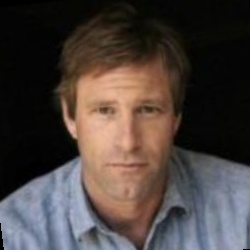

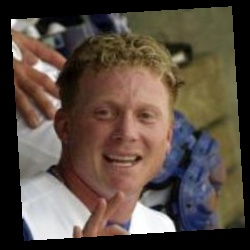

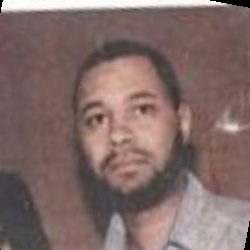

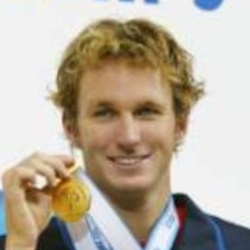

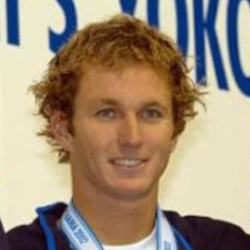

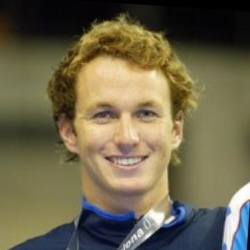

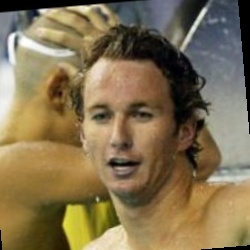

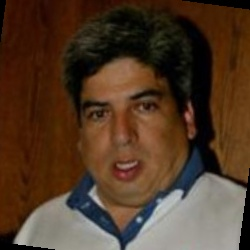

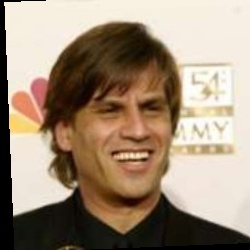

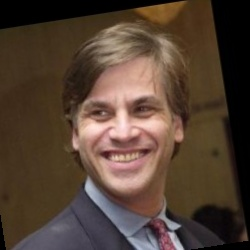

In [8]:
for fich in ficheros_male[:10]:
    imagen = load_img(fich)
    display(imagen)
    print()

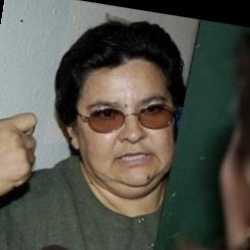

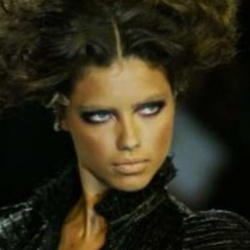

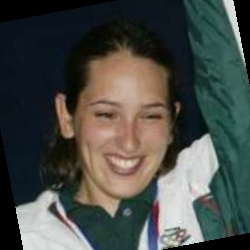

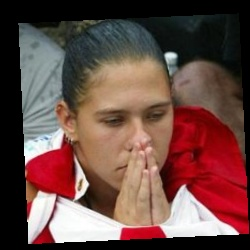

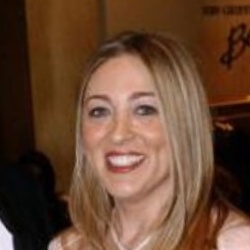

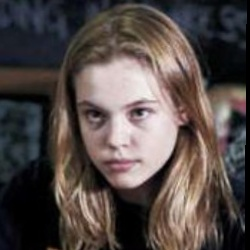

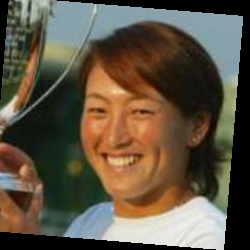

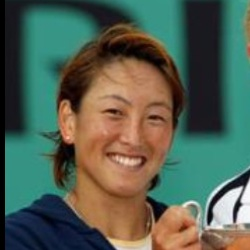

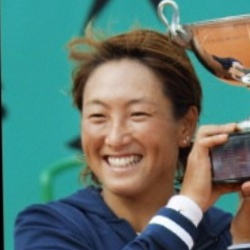

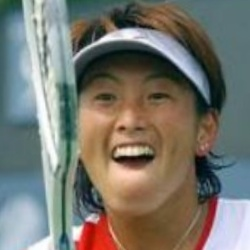

In [9]:
ficheros_female = sorted(glob("./gender/female/*"))
for fich in ficheros_female[:10]:
    imagen = load_img(fich)
    display(imagen)
    print()

### **Función para normalizar los datos**

In [10]:
np.array(imagen)

array([[[ 56,  95,  64],
        [ 54,  93,  62],
        [ 53,  90,  59],
        ...,
        [ 86, 114, 117],
        [ 88, 116, 119],
        [ 88, 116, 119]],

       [[ 54,  93,  62],
        [ 52,  91,  60],
        [ 51,  88,  57],
        ...,
        [ 88, 116, 119],
        [ 88, 116, 119],
        [ 88, 116, 119]],

       [[ 51,  90,  61],
        [ 49,  88,  59],
        [ 47,  86,  57],
        ...,
        [ 88, 116, 117],
        [ 88, 116, 117],
        [ 88, 116, 117]],

       ...,

       [[161, 185, 197],
        [166, 190, 202],
        [172, 194, 207],
        ...,
        [236, 238, 251],
        [238, 240, 253],
        [239, 241, 254]],

       [[163, 187, 199],
        [167, 191, 203],
        [173, 195, 208],
        ...,
        [237, 239, 251],
        [239, 241, 253],
        [240, 242, 254]],

       [[163, 187, 199],
        [168, 192, 204],
        [173, 195, 208],
        ...,
        [237, 239, 251],
        [240, 242, 254],
        [241, 243, 255]]

In [11]:
np.array(imagen).min(), np.array(imagen).max()

(np.uint8(0), np.uint8(255))

In [12]:
preprocess_input = lambda x:x/255

### **Partición training-test**

In [13]:
import pandas as pd

rutas = pd.DataFrame({"path": ficheros_female+ficheros_male, "class": ["female"]*len(ficheros_female) + ["male"]*len(ficheros_male)})
rutas

path   class
0             ./gender/female/Adelina_Avila_0001.jpg  female
1              ./gender/female/Adriana_Lima_0001.jpg  female
2     ./gender/female/Adriana_Perez_Navarro_0001.jpg  female
3            ./gender/female/Adrianna_Zuzic_0001.jpg  female
4               ./gender/female/Afton_Smith_0001.jpg  female
...                                              ...     ...
2148              ./gender/male/Jackie_Chan_0009.jpg    male
2149              ./gender/male/Jackie_Chan_0010.jpg    male
2150              ./gender/male/Jackie_Chan_0011.jpg    male
2151              ./gender/male/Jackie_Chan_0012.jpg    male
2152              ./gender/male/Jackie_Chan_0013.jpg    male

[2153 rows x 2 columns]

Problema: un/a famoso/a puede tener varias fotografías. La idea es que todas ellas deberían estar o bien en training, o en validación, o en test, pero no en varios conjuntos a la vez. Si no, podría ocurrir que en test evaluemos a la red con los mismos personajes con los que hemos entrenado.

Solución: la partición training/validación/test la hago con los personajes. Una vez que tengo esa partición a nivel de personajes, meto en cada conjunto todas las fotos de los personajes correspondientes.

In [14]:
"_".join(ficheros_female[0].split("_")[:-1])

'./gender/female/Adelina_Avila'

In [15]:
ficheros_female2 = ["_".join(ruta.split("_")[:-1]) for ruta in ficheros_female]
ficheros_female2 = sorted(list(set(ficheros_female2)))
etiquetas_female2 = len(ficheros_female2)*["female"]
print(ficheros_female2[:3])
print(etiquetas_female2[:3])

['./gender/female/Adelina_Avila', './gender/female/Adriana_Lima', './gender/female/Adriana_Perez_Navarro']
['female', 'female', 'female']


In [16]:
ficheros_male2 = ["_".join(ruta.split("_")[:-1]) for ruta in ficheros_male]
ficheros_male2 = sorted(list(set(ficheros_male2)))
etiquetas_male2 = len(ficheros_male2)*["male"]
print(ficheros_male2[:3])
print(etiquetas_male2[:3])

['./gender/male/Aaron_Eckhart', './gender/male/Aaron_Guiel', './gender/male/Aaron_Patterson']
['male', 'male', 'male']


In [17]:
rutas2 = ficheros_female2 + ficheros_male2
etiquetas2 = etiquetas_female2 + etiquetas_male2

In [18]:
from sklearn.model_selection import train_test_split

rutas2_trval, rutas2_test, ets2_trval, ets2_test = train_test_split(rutas2, etiquetas2,
                                                                    test_size=0.3, random_state=1,
                                                                    stratify=etiquetas2)
rutas2_tr, rutas2_val, ets2_tr, ets2_val = train_test_split(rutas2_trval, ets2_trval,
                                                                    test_size=0.3, random_state=1,
                                                                    stratify=ets2_trval)

In [19]:
rutas2_tr[:5]

['./gender/male/Antonio_Elias_Saca',
 './gender/female/Jane_Krakowski',
 './gender/male/Bill_Guerin',
 './gender/male/Abdul_Rahman',
 './gender/female/Jayne_Yarris']

In [20]:
rutas2_val[:5]

['./gender/male/Carl_Pope',
 './gender/female/Bridgette_Wilson-Sampras',
 './gender/male/Adel_Al-Jubeir',
 './gender/male/Brian_Billick',
 './gender/female/Amy_Smart']

In [21]:
rutas2_test[:5]

['./gender/male/Brandon_Lloyd',
 './gender/male/Anthony_Mazur',
 './gender/male/Akbar_Al_Baker',
 './gender/female/Alexa_Loren',
 './gender/female/Ann_Godbehere']

In [22]:
# rutas detalladas:
rutas     = ficheros_female + ficheros_male
etiquetas = ["female"]*len(ficheros_female) + ["male"]*len(ficheros_male)

# rutas detalladas por conjunto (tr, val, test):
rutas3_tr = []
ets3_tr = []

rutas3_val = []
ets3_val = []

rutas3_test = []
ets3_test = []

for x,y in zip(rutas, etiquetas):
    aux = "_".join(x.split("_")[:-1])
    if aux in rutas2_tr:
        rutas3_tr.append(x)
        ets3_tr.append(y)
    elif aux in rutas2_val:
        rutas3_val.append(x)
        ets3_val.append(y)
    else:
        rutas3_test.append(x)
        ets3_test.append(y)

In [23]:
len(rutas3_tr) + len(rutas3_val) + len(rutas3_test), len(rutas)

(2153, 2153)

In [24]:
rutas_tr = pd.DataFrame({"path": rutas3_tr, "class": ets3_tr})
rutas_tr

path   class
0     ./gender/female/Adriana_Lima_0001.jpg  female
1      ./gender/female/Ai_Sugiyama_0001.jpg  female
2      ./gender/female/Ai_Sugiyama_0002.jpg  female
3      ./gender/female/Ai_Sugiyama_0003.jpg  female
4      ./gender/female/Ai_Sugiyama_0004.jpg  female
...                                     ...     ...
1052     ./gender/male/Jackie_Chan_0009.jpg    male
1053     ./gender/male/Jackie_Chan_0010.jpg    male
1054     ./gender/male/Jackie_Chan_0011.jpg    male
1055     ./gender/male/Jackie_Chan_0012.jpg    male
1056     ./gender/male/Jackie_Chan_0013.jpg    male

[1057 rows x 2 columns]

In [25]:
rutas_val = pd.DataFrame({"path": rutas3_val, "class": ets3_val})
rutas_val

path   class
0       ./gender/female/Adelina_Avila_0001.jpg  female
1      ./gender/female/Adrianna_Zuzic_0001.jpg  female
2         ./gender/female/Afton_Smith_0001.jpg  female
3      ./gender/female/Agnes_Bruckner_0001.jpg  female
4      ./gender/female/Akiko_Morigami_0001.jpg  female
..                                         ...     ...
450           ./gender/male/Carl_Pope_0001.jpg    male
451         ./gender/male/Chick_Hearn_0001.jpg    male
452         ./gender/male/Chick_Hearn_0002.jpg    male
453         ./gender/male/Chick_Hearn_0003.jpg    male
454  ./gender/male/Corliss_Williamson_0001.jpg    male

[455 rows x 2 columns]

In [26]:
rutas_test = pd.DataFrame({"path": rutas3_test, "class": ets3_test})
rutas_test

path   class
0    ./gender/female/Adriana_Perez_Navarro_0001.jpg  female
1           ./gender/female/Aicha_El_Ouafi_0001.jpg  female
2           ./gender/female/Aicha_El_Ouafi_0002.jpg  female
3           ./gender/female/Aicha_El_Ouafi_0003.jpg  female
4             ./gender/female/Aiysha_Smith_0001.jpg  female
..                                              ...     ...
636              ./gender/male/Byron_Scott_0002.jpg    male
637          ./gender/male/Calvin_Harrison_0001.jpg    male
638     ./gender/male/Carlo_Azeglio_Ciampi_0001.jpg    male
639           ./gender/male/Carlos_Alberto_0001.jpg    male
640           ./gender/male/Chistian_Stahl_0001.jpg    male

[641 rows x 2 columns]

### **Estadísticas de las clases**

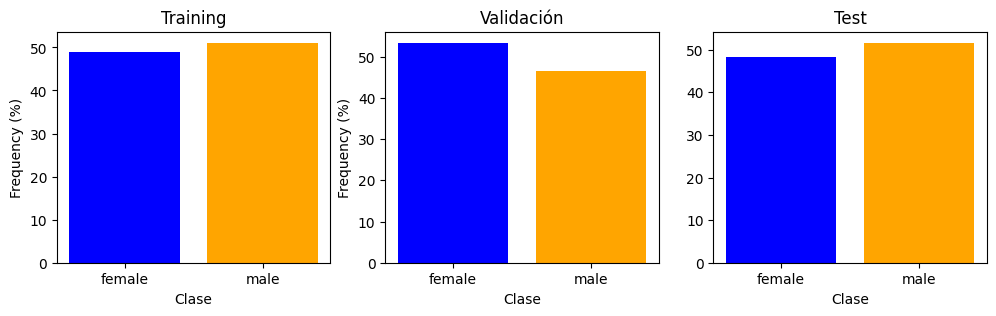

In [27]:
plt.figure(figsize=(12,3))
ax = plt.subplot(1,3,1)
clases, counts = np.unique(rutas_tr["class"], return_counts=True)
plt.bar(clases, 100*counts/len(rutas_tr), color=["blue", "orange"])
plt.title('Training'); plt.xlabel('Clase'); plt.ylabel('Frequency (%)'); ax.set_xticks(clases)

ax = plt.subplot(1,3,2)
clases, counts = np.unique(rutas_val["class"], return_counts=True)
plt.bar(clases, 100*counts/len(rutas_val), color=["blue", "orange"])
plt.title('Validación'); plt.xlabel('Clase'); plt.ylabel('Frequency (%)'); ax.set_xticks(clases)

ax = plt.subplot(1,3,3)
none, counts = np.unique(rutas_test["class"], return_counts=True)
plt.bar(clases, 100*counts/len(rutas_test), color=["blue", "orange"])
plt.title('Test'); plt.xlabel('Clase'); ax.set_xticks(clases); plt.show()

## **Implementación en Keras de un modelo que clasifique una cara en color en female / male**

In [28]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)
normed_dims

(150, 150)

In [29]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras import optimizers

model = Sequential()

# Rellenar


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

I0000 00:00:1736512679.714058   11379 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## **Entrenamiento del modelo**

In [33]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

In [34]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

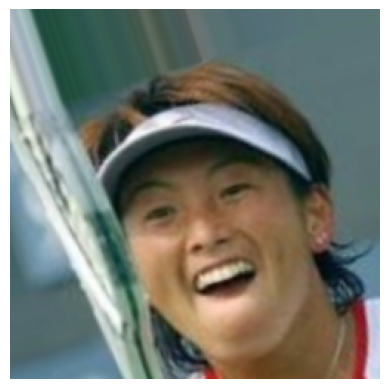

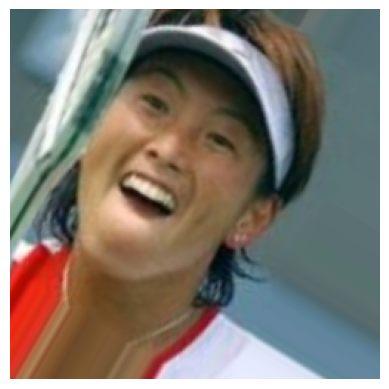

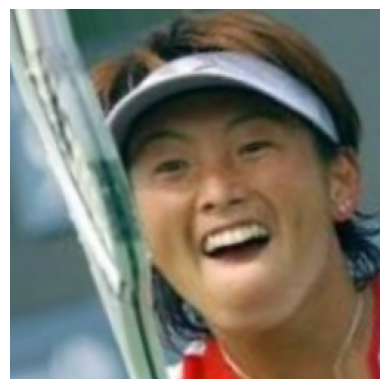

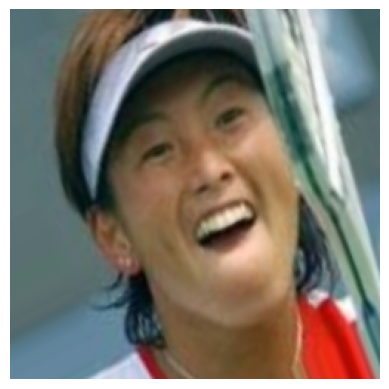

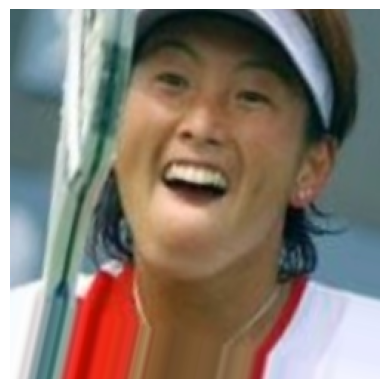

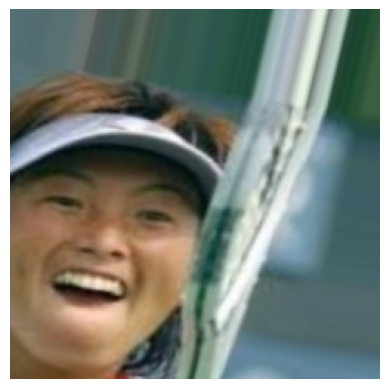

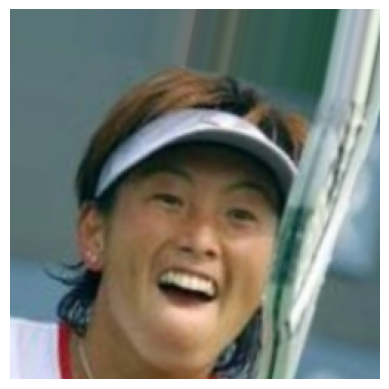

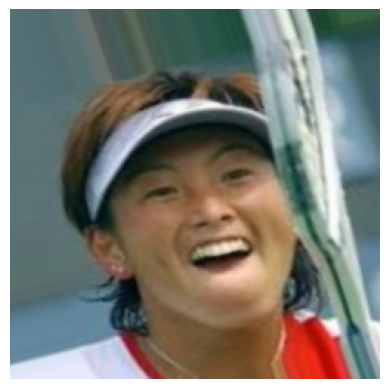

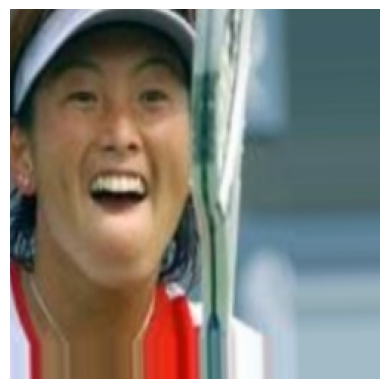

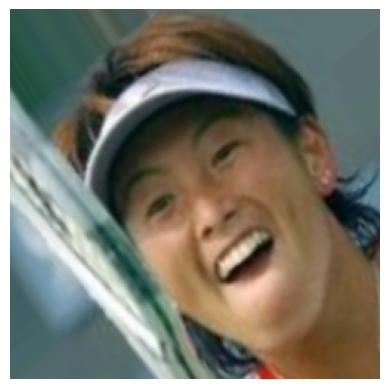

In [35]:
imagen_num = np.expand_dims(np.array(imagen), axis=0)
for i in range(10):
    plt.imshow(train_datagen.flow(imagen_num)[0][0])
    plt.axis("off")
    plt.show()

In [ ]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=rutas_tr,
    x_col="path",
    y_col="class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    #color_mode="grayscale",
    class_mode='categorical') # binary, categorical, sparse

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=rutas_val,
    x_col="path",
    y_col="class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    #color_mode="grayscale",
    class_mode='categorical') # binary, categorical, sparse

test_generator = test_datagen.flow_from_dataframe(
    dataframe=rutas_test,
    x_col="path",
    y_col="class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    #color_mode="grayscale",
    class_mode='categorical') # binary, categorical, sparse

In [ ]:
train_generator.class_indices

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

In [ ]:
from keras.callbacks import ModelCheckpoint

modelpath="best_model.h5"

epochs = 100

checkpoint = ModelCheckpoint(modelpath, monitor='val_loss', verbose=1,
                             save_best_only=True,
                             mode='min') # graba sólo los que mejoran en validación

serie_tr_acc = []
serie_val_acc = []
serie_tr_loss  = []
serie_val_loss = []

In [ ]:
for e in range(epochs):
    salida = model.fit(train_generator,
                       steps_per_epoch=number_train_samples // batch_size,
                       epochs=1,
                       callbacks=[checkpoint],
                       verbose=1,
                       shuffle = True,
                       validation_data=validation_generator,
                       validation_steps=number_val_samples // batch_size
                      )

    serie_tr_acc.append(salida.history["accuracy"][0])
    serie_val_acc.append(salida.history["val_accuracy"][0])
    serie_tr_loss.append(salida.history["loss"][0])
    serie_val_loss.append(salida.history["val_loss"][0])

    clear_output()
    grafica_entrenamiento(serie_tr_acc, serie_val_acc,
                          serie_tr_loss, serie_val_loss)

Recupero el mejor modelo (punto rojo), que está grabado en el fichero dado por la variable modelpath:

In [ ]:
from keras.models import load_model

model = load_model(modelpath)

## **Análisis de los resultados del modelo**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc

y_real = np.array(test_generator.classes)
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))

In [ ]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen2.flow_from_dataframe(
    dataframe=rutas_test,
    x_col="path",
    y_col="class",
    target_size=normed_dims,
    batch_size=test_generator.n, # todas las imágenes del directorio test
    shuffle=False,
    class_mode='categorical')

In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()
class_indices = test_generator2.class_indices
class_indices

In [ ]:
ind_te1 = 0 # 1500

image = X_te[ind_te1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["female"]]
print("Probabilidad female: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["male"]]
print("Probabilidad male : {:2.1f}%".format(100*p))

## **Visualización del funcionamiento de la red**

In [ ]:
from keras.models import Model

ejemplo = 0

# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_te[ejemplo:(ejemplo+1)])

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

### **GradCam:**

(de https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

1- Calcular para una imagen la salida del modelo y la salida de la última capa convolucional

2- Encuentrar la neurona de salida más activa (que es la que determina la clase predicha)

3- Calcular el gradiente de dicha neurona de salida con respecto a la última capa convolucional

3- Promediar y pesar esto con la salida de la última capa convolucional

4- Normalizar entre 0 y 1 para visualizar

5- Convertir a RGB y superponerla a la imagen original

In [ ]:
import tensorflow as tf
import cv2
from keras import backend as K

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im, heatmap_factor=0.5, cmap=cv2.COLORMAP_HOT):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen

    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]

    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap

    img = imag[0]

    img = np.zeros((im.shape[0],im.shape[1],3))
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]


    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cmap) / 255


    im2 = (im - im.min()) / (im.max() - im.min())
    superimposed_img = (1-heatmap_factor)*im2 + heatmap_factor*heatmap

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im2, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    prob = 100*model.predict(imag)[0][class_indices["female"]]
    print("Probabilidad clase female : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["male"]]
    print("Probabilidad clase male: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

**Visualización de mapas de sensibilidades (heatmaps) en varios ejemplos:**

In [ ]:
ind = 20

for i in range(ind, ind+10):
    show_heatmap(model, X_te[i])

In [ ]:
for _ in range(20):
    ind = np.random.randint(len(X_te))
    show_heatmap(model, X_te[ind])